# COMP64101 - Inference Lab

### Goals of This Weeks lab:

1. Understand Monte Carlo Estimation
2. Understand Markov Chain Monte Carlo Methods

In [1]:
# Run this cell first!
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

def plot_human_utility():
    xs = np.arange(0.5,60,0.5)
    ys = np.log(xs)

    plt.figure()
    plt.plot(xs,ys)
    plt.title("A plot of Human Utility for Different Levels of Income")
    plt.xlabel("Income (£1000's)")
    plt.ylabel("Associated Utility")
    plt.show()


def mcs_sample_human_utility():
    mean = 3
    sd = .1
    x = np.random.normal(mean, sd)
    return x

## Learning Human Game Strategies <a class="anchor" id="0.5"></a>

<h3>What does it mean to learn human goals?</h3>

While humans often perform predictable actions, such as eating when they are hungry or sleeping when they are tired, human behaviour is often very hard to predict. The main reason for this is that the human brain is able to optimize over huge numbers of potential action/reward spaces.
    
Consider the goals of a person who is trying to win a combat game such as Call of Duty Online. It is extremely difficult to write these factors into an equation which can model their behaviour.

If you sit for a few hours, you may be able to come up with many factors which determine human behaviour. However, I am very confident that you won't get them all! I am also confident that you will strugle to write these into an equation. Researchers from many fields are trying to better understand human behaviour. Throughout this notebook, we will use MCMC techniques along with some simplistic utility functions to try to predict human goals.


<h3>A simplistic Model for Human Behaviour!</h3>

<h4>Utility functions</h4>

In economics and decision theory, a utility function is used to assign preferences over a set or actions of outcomes. It is common to see plots such as the one below:

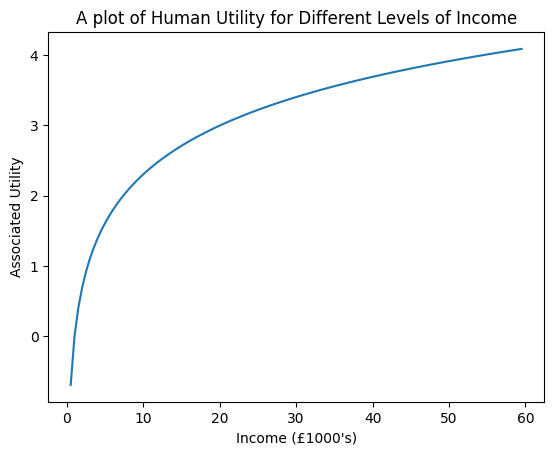

In [2]:
plot_human_utility()

<script>
  function searchCellsByTag(tag) {
    // Get the notebook's cell list
    var cells = Jupyter.notebook.get_cells();
      
    // Iterate through each cell
    cells.forEach(function(cell, index) {
      // Check if the cell has metadata tags
      if (cell.metadata.tags && cell.metadata.tags.includes(tag)) {
        console.log('Cell', index, 'has the tag:', tag);
        // You can perform additional actions here, such as highlighting the cell
        cell.element.css('border', '2px solid red');
      }
    });
  }

  // Example usage: search for cells with the tag 'my_tag'
  searchCellsByTag('test_tag');
</script>

This artificial plot implies that initially small increases in income are desireable for the person but eventually this will level out and much larger income shifts are needed to get the same level of desirability. These types of plots can easily be adapted to AI settings, where the goals of a human need to be modelled. This is common in AI assistance problems for example, where an AI assistant tries to predict the goals of a human and recommends actions to take.

<h4>A simplistic Approximation to Utility of Gamers</h4>

As previously stated, it is difficult to fully model a human's goals. However, we can begin to make simple approximations by considering the goals with highest priority.

Let us consider the utility of someone who is playing Call of Duty. The player will probably have some willingness to use ammunition (the utility function itself) and an estimated amount of ammo to beat the opponent (the parameter of the utility function). We model this with a function $f_\omega^{(1)} (s)$

$$ f_\omega^{(1)} (s_i) = 1 - \Phi(s_i)$$

where $\Phi(d)$ the cdf of a normal distribution $N(\mu, \sigma)$ at x=$d$ and $s$ is a vector of parameters representing the scenario. For example, $s_1$ represents the predicted amount of ammo needed to beat the opponent.

The gamer will also consider the probability of success against their opponent. This can be modelled as follows:
$$ f_\omega^{(2)} (s) = p(\text{success} | s_2)$$

which represents the probability of beating the opponent given their level $s_2$.

We can combine this into a utility function as follows:

$$ U(s) = f_\omega^{(1)} (s) f_\omega^{(2)}(s)$$

## 1.  Monte Carlo Approximation<a class="anchor" id="1"></a>

Monte Carlo approximation is a technique which is used to estimate statistical results through random sampling. The algorithm simply draws random samples from the distribution and looks at the statistics of those specific samples. For example, the expected value can be written as follows:

$$ \mathbb{E}[X] \approx \frac{1}{N} \sum_{i=1}^{N} x_i$$

The key to this approximation method is that we must be able to draw samples from the distribution. Lets say that the gamer's willingness to use ammo can be modelled by a $N(\mu, 0.1)$ distribution but we don't know the value of $\mu$. In an AI setting, we could sample the distribution by observing the gamers behaviour or directly recommending actions.

Below is a plot which shows how the predicted mean varies upon taking more samples from the distribution.

Text(0, 0.5, 'Mean')

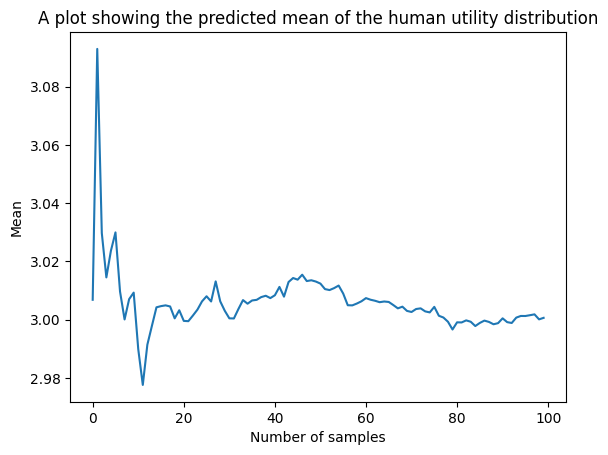

In [3]:
N = 100
all_samples = []
mean_prediction = []
for i in range(0,N):
    sample = mcs_sample_human_utility()
    all_samples.append(sample)
    mean_prediction.append(np.mean(all_samples))

plt.figure()
plt.plot(range(0,N),mean_prediction)
plt.title("A plot showing the predicted mean of the human utility distribution")
plt.xlabel("Number of samples")
plt.ylabel("Mean")

The distribution of these predictions can also be visualised by running multiple iterations of the sample process. This gives us a distribution of possible mean values. This is seen below:

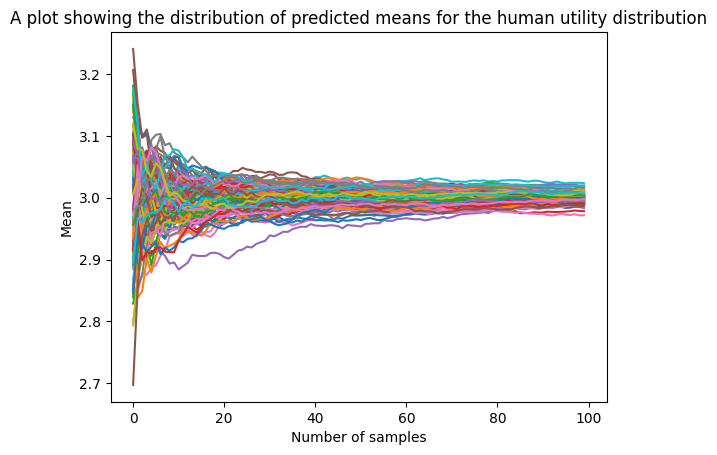

In [4]:
num_plots = 100
for j in range(0, num_plots):
    all_samples = []
    mean_prediction = []
    for i in range(0,N):
        sample = mcs_sample_human_utility()
        all_samples.append(sample)
        mean_prediction.append(np.mean(all_samples))

    plt.plot(range(0,N),mean_prediction)

plt.title("A plot showing the distribution of predicted means for the human utility distribution")
plt.xlabel("Number of samples")
plt.ylabel("Mean")
plt.show()

Using the plot above, we can conclude that the gamers willingness to use ammo is around 3.

## 2. An Introduction to Markov Chain Monte Carlo (MCMC) <a class="anchor" id="2"></a>

Using Monte Carlo estimation is great when we can sample from a distribution. However, there are times when we can't sample directly from a distribution. Lets say we are using Bayes rule to calculate a posterior distribution i.e.:

$$ P(A | B) = \frac{P (B | A) P(A)}{P(B)} = \frac{P (B | A) P(A)}{\int_{-\infty}^{\infty} P (B | A) P(A)dx_A} $$

In many of the cases you have seen before, $P(A|B)$ might have been easy to sample from, such as in the cases where $P(A|B)$ is in the form of a known distribution. However, in most complex problems, it is a complex function that doesn't match any known distributions. Markov Chain Monte Carlo gives us a way to sample from these distributions.

#### Markov Chains

A Markov chain is a sequence of random variables $X_1, X_2, X_3, ...$ which satisfy the markov property:

For any $n \in \mathbb{N}$:

$$P(X_n = i_n | X_{n-1} = i_{n-1}) = P(X_n = i_n | X_{0} = i_{0}, X_{1} = i_{1}, ...,  X_{n-1} = i_{n-1}) $$

In other words, we only need to know the previous state in order to calculate the next state.


The goal of MCMC methods is to generate a Markov chain where each random variable represents a sample from the target distribution.

#### Running Example

Using the human utility example, we know that the human's propensity to use ammo can be modelled by a $N(\mu, 0.1)$ distribution. We ask an expert about what value $\mu$ can take. They don't know exactly but narrow it down to a range between 2 and 6. Furthermore, we run some human trials and get the following values [3.1, 2.65]. We can calculate the likelihood by the following:

$$P(data | \mu, \sigma) = \prod_{i=0}^1 \frac{1}{\sqrt{2 \pi \sigma^2}} e^{\frac{-(x_i - \mu)^2}{2 \sigma^2}}$$

$$P(data | \mu, \sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} e^{\frac{-(3.1 - \mu)^2}{2 \sigma^2}} \frac{1}{\sqrt{2 \pi \sigma^2}} e^{\frac{-(2.65 - \mu)^2}{2 \sigma^2}}$$

$$P(data | \mu, \sigma) = \frac{1}{2 \pi \sigma^2} e^{\frac{-1}{2 \pi \sigma^2} \left( (3.1 - \mu)^2 + (2.65 - \mu)^2 \right)} $$

We can combine this with a uniform(2,6) prior and $\sigma=0.1$ as follows: (this is 6-2 in the denominator since the integral of the pdf is 1: 1/(6-2)*(6-2))

$$ P(data | \mu) P (\mu) = \frac{1}{2 \pi \sigma^2} e^{\frac{-1}{2 \pi \sigma^2} \left( (3.1 - \mu)^2 + (2.65 - \mu)^2 \right)} * \frac{1}{6 - 2}$$

$$ P(data | \mu) P (\mu) = \frac{1}{0.08 \pi} e^{\frac{-1}{0.02 \pi} \left( (3.1 - \mu)^2 + (2.65 - \mu)^2 \right)}$$

where the function is 0 for all values outside the range [2,6].

This can be visualised as follows:

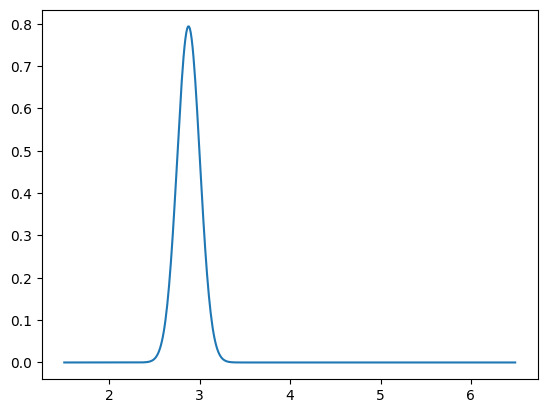

In [5]:
xs = np.arange(1.5,6.5,0.01)
valid_mask = (xs >= 2) & (xs <= 6)
ys = np.zeros_like(xs)
ys[valid_mask] = 1/(0.08 * np.pi) * np.exp(-1/(0.02 * np.pi) * ((3.1 - xs[valid_mask])**2 + (2.65 - xs[valid_mask])**2))

plt.plot(xs, ys)
plt.show()

By looking at the plot, we see that this follows a normal distribution with mean around 2.9. However, it's hard to know the exact parameters.

In some cases, the distribution may follow some distribution which is entirely unrecognisable. This is where MCMC methods come in.

### 2.1. Metropolis

In this section, we will explore the Metropolis algorithm, a Markov Chain Monte Carlo (MCMC) method used to sample from a probability distribution. It does this by generating a Markov chain of samples $X_1, X_2, X_3,...$ from the distribution. The Metropolis algorithm is the original form of this class of algorithms and lays the foundations for more advanced algorithms, such as the Metropolis-Hastings algorithm.   

#### Stationary Distribution

The stationary distribution of a Markov Chain is reached when the probability distribution it represents remains unchanged over time. This means that if a Markov chain is in its stationary distribution, then after any number of transitions, the distribution of the states remains the same.This is represented mathematically as:

$$\pi(x) = \sum_{x'} \pi(x')P(x' \rightarrow x)$$

where $P$ is the transition probability. The equation can be interpreted as the probability of being in a state $x$ after one transition is the same as before the transition i.e. stationary.

This seems like a good property for our Markov chain to have. Essentially it tells us that once one sample from the stationary distribution (target distribution) as been obtained, all other samples will belong to that distribution.

#### Simple Markov Chain Example

Let's start by simulating a simple Markov chain. The transition matrix $P$ below defines the probabilities of moving from one state to another. This matrix is 3x3, so it represents a state space with $3$ states.

In [6]:
# Define the transition matrix
P = np.array([
    [0.1, 0.6, 0.3],
    [0.4, 0.4, 0.2],
    [0.2, 0.3, 0.5]
])

To simulate the Markov chain for $n$ steps, we repeatedly use the proabilities from the $i^{\text{th}}$ row of P to generate the distribution of transitions. The random.choice class picks the next state according to the distribution and the next state is updated.

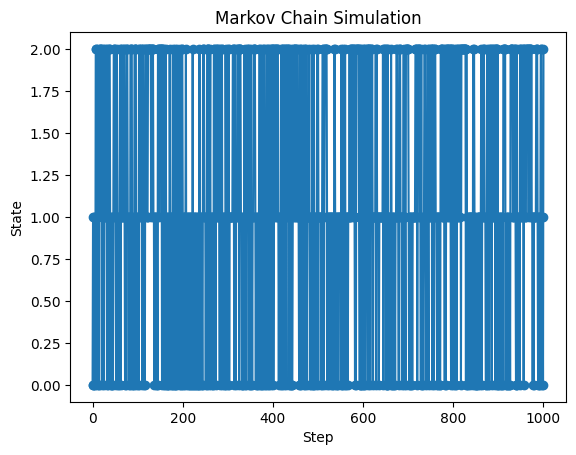

In [7]:
# Number of steps to simulate
n_steps = 1000

# Initialize the state
state = 0
states = [state]

# Simulate the Markov chain
for _ in range(n_steps):
    state = np.random.choice([0, 1, 2], p=P[state])
    states.append(state)

# Plot the results
plt.plot(states, 'o-')
plt.xlabel('Step')
plt.ylabel('State')
plt.title('Markov Chain Simulation')
plt.show()

One way to estimate the stationary distribution is to look at the proportion of time the Markov chain spends in each state. For example:

In [8]:
print("Proportion of zeros: {}".format(states.count(0)/len(states)))
print("Proportion of ones: {}".format(states.count(1)/len(states)))
print("Proportion of twos: {}".format(states.count(2)/len(states)))

Proportion of zeros: 0.24475524475524477
Proportion of ones: 0.4195804195804196
Proportion of twos: 0.3356643356643357


You can also do this more acurately by solving the equation $\pi P = \pi$, where $\pi$ is the stationary distribution vector, and $P$ is the transition matrix. Try this with pen and paper.

This can also be done with code. Check your answer matches the output:

In [9]:
# Solve for the stationary distribution
eigenvalues, eigenvectors = np.linalg.eig(P.T)
stationary_dist = eigenvectors[:, np.isclose(eigenvalues, 1)]
stationary_dist = stationary_dist[:, 0]
stationary_dist = stationary_dist / stationary_dist.sum()  # Normalize
print('Stationary Distribution:', stationary_dist.real)

Stationary Distribution: [0.25806452 0.41935484 0.32258065]


#### Detailed Balance

The detailed balance condition is one way to ensure that the desired distribution is the stationary distribution of the Markov chain. In other words, it ensures that the above property holds. For a Markov chain with a transition probability matrix $P(x \rightarrow x')$, the detailed balance condition requires that for every pair of states $x$ and $x'$, the following equation holds:

$$\pi(x)P(x \rightarrow x') = \pi(x')P(x' \rightarrow x)$$

Where $\pi(x)$ is the stationary distribution of the Markov chain. If the detailed balance condition holds, then the Markov chain will eventually converge to the stationary distribution. The equation can be interpreted as the rate at which transitions from $x$ to $x'$ occur is the same as $x'$ to $x$.


The Metropolis Algorithm Steps:
  1. **Initialization:** Start with an initial state $x_0$
  2. **Proposal Step:** Generate a proposed state $x^*$ from an arbitrary proposal distribution $q(x^* | x_t)$.
  3. **Acceptance Step:** Compute the acceptance probability:
  $$ \alpha = \min \left( 1, \frac{\pi (x^*)}{\pi(x_t)} \right)$$
  If accepted, move to the new state $x^*$; otherwise, stay in the current state x.
  4. **Iteration:** Repeat the proposal and acceptance steps for the required number of iterations to generate the Markov chain.

Satisfying detailed balance means that the distribution is stationary, since:

1. There is no net flow between states. i.e. over time, the transitions between states "cancel out" each other, preventing any long-term drift in the distribution of states.

2. Since the inflow and outflow of probability between any two states are equal, the overall probability distribution does not change over time, meaning that the distribution remains stationary.

#### Example code:

First we create a function which represents the probability of data given $\mu$:

In [10]:
# First, we define the unnormalized target distribution
def target_distribution(mu):
    # Constants as given in the equation
    c1, c2 = 3.1, 2.65
    constant = 1 / (0.08 * np.pi)
    exponent = -1 / (0.02 * np.pi) * ((c1 - mu)**2 + (c2 - mu)**2)
    return constant * np.exp(exponent)


We now wish to find the probability of $\mu$ given the data, using metropolis:

In [11]:
# Metropolis algorithm
def metropolis_sampling(start_mu, n_samples, proposal_width):
    samples = []
    mu_current = start_mu
    samples.append(mu_current)

    for i in range(n_samples):
        # Propose a new candidate mu from a normal distribution
        mu_proposal = np.random.normal(mu_current, proposal_width)

        # Compute acceptance probability
        acceptance_ratio = target_distribution(mu_proposal) / target_distribution(mu_current)

        # Accept or reject the proposal
        if np.random.rand() < acceptance_ratio:
            mu_current = mu_proposal  # Accept the proposal

        samples.append(mu_current)

    return np.array(samples)

We can now run metropolis with an initial guess of 2 for 1,000 iterations.

In [12]:
# Parameters for sampling
start_mu = 1.5  # Initial guess for mu
n_samples = 1000  # Number of samples to generate
proposal_width = 0.2  # Width of the proposal distribution

# Run the Metropolis sampler
samples = metropolis_sampling(start_mu, n_samples, proposal_width)

We can plot a histogram of the predicted value for mu by plotting the samples.

<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-1014332685.py:3: SyntaxWarning: invalid escape sequence '\m'
  plt.title('Sampled Distribution of $\mu$')
/tmp/ipython-input-1014332685.py:4: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('$\mu$')


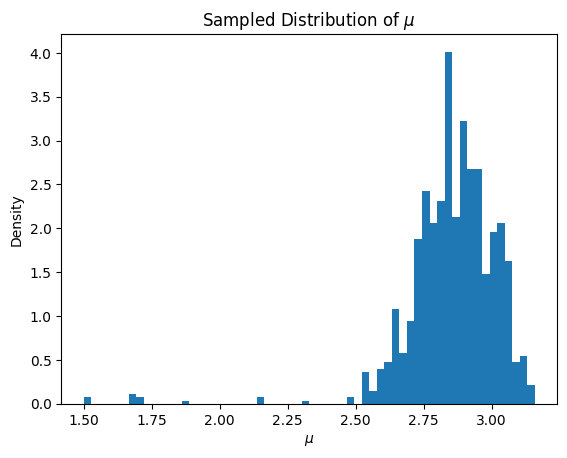

In [13]:
# Plot the sampled distribution
plt.hist(samples, bins=60, density=True)
plt.title('Sampled Distribution of $\mu$')
plt.xlabel('$\mu$')
plt.ylabel('Density')
plt.show()

Furthermore, we can observe the markov chain. Specifically, we look at the first 250 samples.

<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-2040709494.py:3: SyntaxWarning: invalid escape sequence '\m'
  plt.title('Sampled Markov chain of $\mu$')
/tmp/ipython-input-2040709494.py:5: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('$\mu$')


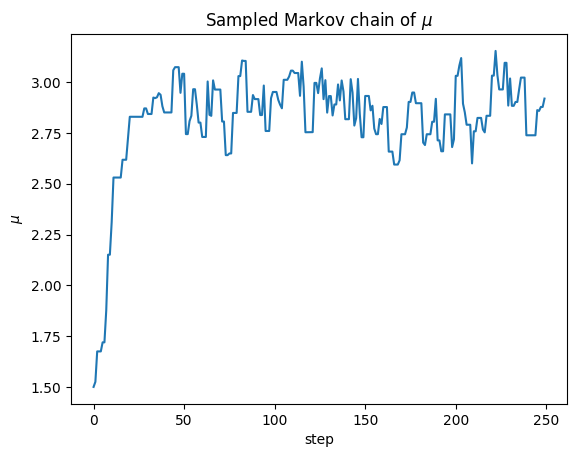

In [14]:
# Plot the markov chain
plt.plot(samples[:250])
plt.title('Sampled Markov chain of $\mu$')
plt.xlabel('step')
plt.ylabel('$\mu$')
plt.show()

By looking at this plot, we can estimate when the Markov chain has converged to the stationary distribution. Notice how there is a trail of outliers in the first 15 or so steps!

In some cases, the Markov chain may take longer to converge. This can have considerable effect on our prediction for the relevant parameter. To counteract this, we discard the first $n$ samples. This is a process known as setting the 'Burn In' value. Can you select an appropriate value for the burn in?

Plot the markov chain and the parameter distribution below after considering an appropriate burn in:

<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-3211389360.py:7: SyntaxWarning: invalid escape sequence '\m'
  plt.title('Sampled Markov chain of $\mu$ with burn in')
/tmp/ipython-input-3211389360.py:9: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('$\mu$')


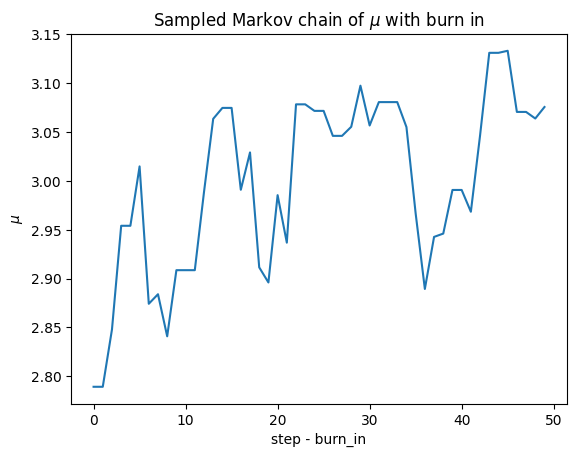

In [22]:
# Plot your solution here:

burn_in =200

# Plot the markov chain
plt.plot(samples[burn_in:250])
plt.title('Sampled Markov chain of $\mu$ with burn in')
plt.xlabel('step - burn_in')
plt.ylabel('$\mu$')
plt.show()

<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-3270847482.py:6: SyntaxWarning: invalid escape sequence '\m'
  plt.title('Sampled Markov chain of $\mu$ with burn in')
/tmp/ipython-input-3270847482.py:8: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('$\mu$')


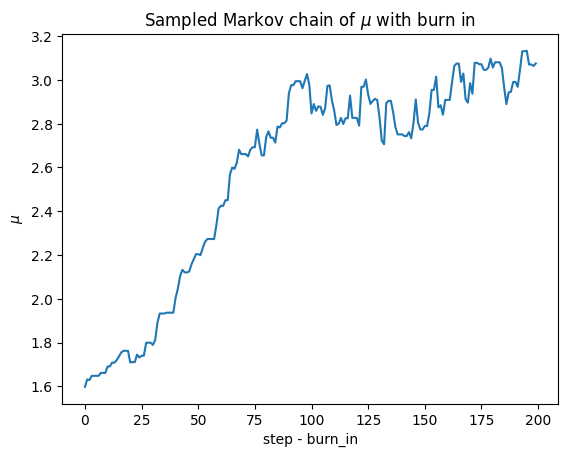

In [23]:
# Begin Solution:
burn_in = 50

# Plot the markov chain
plt.plot(samples[burn_in:250])
plt.title('Sampled Markov chain of $\mu$ with burn in')
plt.xlabel('step - burn_in')
plt.ylabel('$\mu$')
plt.show()

# End Solution

##### Begin Solution
By setting a burn-in of 50, we remove the samples where the algorithm was converging to the stationary distribution!
##### End Solution

### 2.2. Metropolis-Hastings

The Metropolis-Hastings algorithm is a generalization of the Metropolis algorithm, which was covered in the previous section. These methods are used to generate samples from complex probability distributions, particularly when direct sampling is challenging. The Metropolis-Hastings algorithm extends the original Metropolis algorithm by introducing an asymetric approach to the proposal distribution, making it applicable to a broader range of problems.

The Metropolis-Hastings Algorithm Steps:
  1. **Initialization:** Start with an initial state $x_0$
  2. **Proposal Step:** Generate a proposed state $x^*$ from an arbitrary proposal distribution $q(x^* | x_t)$, which does not need to be symmetric.
  3. **Acceptance Step:** Compute the acceptance probability:
  $$ \alpha = \min \left( 1, \frac{\pi (x^*) \cdot q(x_t | x^*)}{\pi(x_t) \cdot q(x^* | x_t)} \right)$$
  
  Here, the acceptance probability accounts for the asymmetry in the proposal distribution. Accept the proposed state $x^*$ with probability $\alpha.$ If the proposal is rejected, the chain remains at the current state $x_t$.
  4. **Iteration:** Repeat the proposal and acceptance steps for the required number of iterations to generate the Markov chain.

#### Differences Between Metropolis and Metropolis-Hastings

The key differences between the Metropolis and Metropolis-Hastings algorithms lie in the flexibility and generality of the proposal distribution:

  1. **Asymetric Proposal Distribution:**

  The Metropolis-Hastings algorithm allows the use of an asymmetric proposal distirbution. This means that the Metropolis algorithm is still a Metropolis-Hastings algorithm, since the asymmetry isn't strict.

  2. **Acceptance Probability:**

  In the Metropolis-Hastings algorithm, the acceptance probability $\alpha$ contains aditional terms $q(x_t | x^*)$ and $q(x^* | x_t)$ to account for the asymmetry.

  3. **Flexibility:**

  The abiliity to use an asymmetric probosal distribution allows for more tailored exploration of the state space. This can potentially lead to faster convergence, particularly in higher-dimensional or complex distributions.

#### Running Example

Continuing with the same example as before, we modify the proposal distribution to be a log-normal. This is an asymmetric distribution, so Metropolis-Hastings must be used.

First, we define the proposal distributions:

In [17]:
# Log-normal proposal distribution
def proposal(mu_current, proposal_width):
    # Propose a new candidate mu from a log-normal distribution (asymmetric)
    return np.random.lognormal(mean=np.log(mu_current), sigma=proposal_width)

# The probability density of the log-normal proposal
def proposal_density(mu_new, mu_current, proposal_width):
    # Log-normal PDF: f(x|μ,σ) = (1 / (xσ√2π)) exp(-(ln(x)−μ)^2 / 2σ^2)
    if mu_new <= 0:  # Log-normal is undefined for non-positive values
        return 0
    return (1 / (mu_new * proposal_width * np.sqrt(2 * np.pi))) * \
           np.exp(- (np.log(mu_new) - np.log(mu_current))**2 / (2 * proposal_width**2))


Next, we define the Metropolis-Hastings algorithm:

In [18]:
# Metropolis-Hastings algorithm
def metropolis_hastings_sampling(start_mu, n_samples, proposal_width):
    samples = []
    mu_current = start_mu
    samples.append(mu_current)

    for i in range(n_samples):
        # Propose a new candidate mu from the asymmetric proposal distribution
        mu_proposal = proposal(mu_current, proposal_width)

        # Calculate the acceptance ratio, adjusted by the proposal densities
        acceptance_ratio = (target_distribution(mu_proposal) / target_distribution(mu_current)) * \
                           (proposal_density(mu_current, mu_proposal, proposal_width) / proposal_density(mu_proposal, mu_current, proposal_width))

        # Accept or reject the proposal
        if np.random.rand() < acceptance_ratio:
            mu_current = mu_proposal  # Accept the proposal

        samples.append(mu_current)

    return np.array(samples)

Notice how this is similar to the Metropolis algorithm but we modify the acceptance ratio to account for the asymmetry.

Below, we run the algorithm and plot the predicted distribution.

<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-3504916086.py:11: SyntaxWarning: invalid escape sequence '\m'
  plt.title('Sampled Distribution of $\mu$ (Asymmetric Metropolis-Hastings)')
/tmp/ipython-input-3504916086.py:12: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('$\mu$')


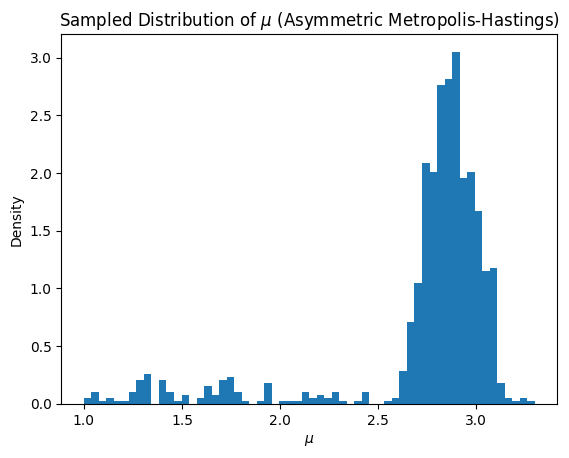

In [19]:
# Parameters for sampling
start_mu = 1  # Initial guess for mu
n_samples = 1000  # Number of samples to generate
proposal_width = 0.025  # Width of the proposal distribution

# Run the Metropolis-Hastings sampler
samples = metropolis_hastings_sampling(start_mu, n_samples, proposal_width)

# Plot the sampled distribution
plt.hist(samples, bins=60, density=True)
plt.title('Sampled Distribution of $\mu$ (Asymmetric Metropolis-Hastings)')
plt.xlabel('$\mu$')
plt.ylabel('Density')
plt.show()

Again, we plot the Markov Chain:

<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-3518260197.py:3: SyntaxWarning: invalid escape sequence '\m'
  plt.title('Sampled Markov chain of $\mu$')
/tmp/ipython-input-3518260197.py:5: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('$\mu$')


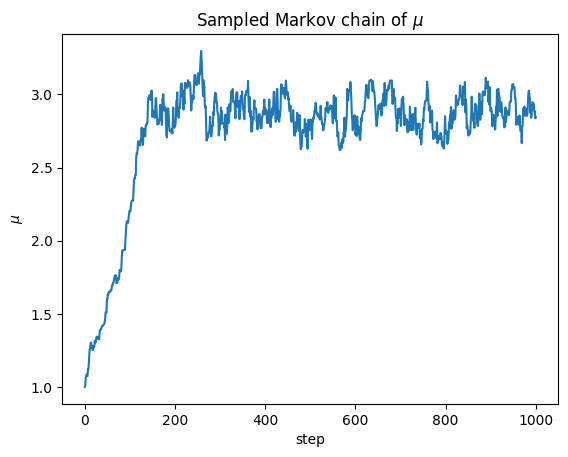

In [20]:
# Plot the markov chain
plt.plot(samples)
plt.title('Sampled Markov chain of $\mu$')
plt.xlabel('step')
plt.ylabel('$\mu$')
plt.show()

Try to find an appropriate burn in rate for this Markov Chain

<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-696597592.py:7: SyntaxWarning: invalid escape sequence '\m'
  plt.title('Sampled Markov chain of $\mu$ with burn in')
/tmp/ipython-input-696597592.py:9: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('$\mu$')


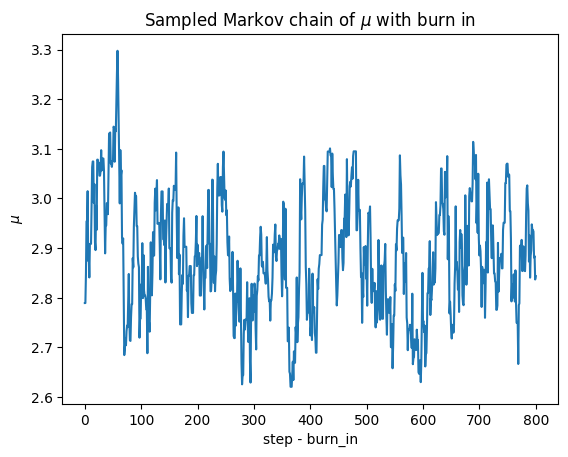

In [24]:
# Plot your solution here:

burn_in =200

# Plot the markov chain
plt.plot(samples[burn_in:])
plt.title('Sampled Markov chain of $\mu$ with burn in')
plt.xlabel('step - burn_in')
plt.ylabel('$\mu$')
plt.show()

<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-3601252832.py:7: SyntaxWarning: invalid escape sequence '\m'
  plt.title('Sampled Markov chain of $\mu$ with burn in')
/tmp/ipython-input-3601252832.py:9: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('$\mu$')


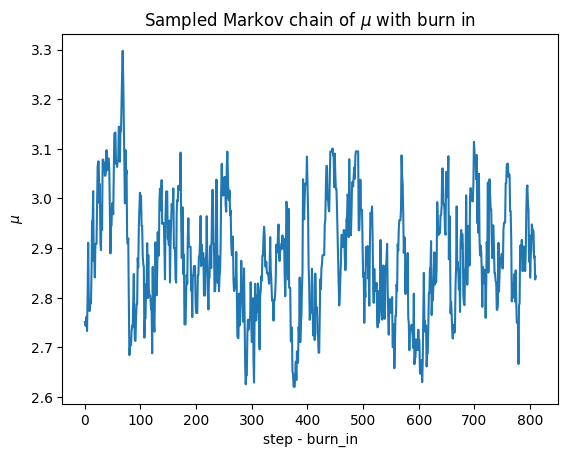

In [25]:
# Begin Solution:

burn_in = 190

# Plot the markov chain
plt.plot(samples[burn_in:])
plt.title('Sampled Markov chain of $\mu$ with burn in')
plt.xlabel('step - burn_in')
plt.ylabel('$\mu$')
plt.show()

# End Solution

This time, we have a higher burn-in due to slower convergence of the algorithm.

Experiment with the parameters of this algorithm. Notice what happens when you change the start_mu or proposal_width.

### 2.3. Gibbs Sampling

Gibbs Sampling is a Markov Chain Monte Carlo (MCMC) method used for generating samples from a joint probability distribution when direct sampling is difficult. It is particularly effective when dealing with high-dimensional distributions. Instead of sampling from the full joint distribution, Gibbs Sampling samples each variable in turn, conditioned on the current values of the other variables. Over many iterations, this process produces samples that approximate the true joint distribution. This decomposition allows for efficient sampling in complex models, especially in Bayesian networks and hierarchical models.

#### The Gibbs Sampling Process

1. **Initialization**: Start with an initial value for each variable.
2. **Sampling**: For each variable, sample from its conditional distribution given the current values of all other variables.
3. **Iteration**: Repeat the process for a large number of iterations to approximate the joint distribution.


#### Simple Example: Binary Variables

Consider a simple model with two binary variables $X_1$ and $X_2$, where each variable can take the value 0 or 1. Suppose we know the following conditional distributions:

- $ P(X_1 | X_2 = 0) = 0.3$ and $P(X_1 | X_2 = 1) = 0.8$
- $P(X_2 | X_1 = 0) = 0.4 $ and $P(X_2 | X_1 = 1) = 0.7$

We want to sample from the joint distribution \( P(X_1, X_2) \) using Gibbs Sampling.

#### Gibbs Sampling Implementation

Here's how you might implement Gibbs Sampling for this simple two-variable case:


In [26]:
# Define the conditional probabilities
def sample_x1_given_x2(x2):
    return np.random.rand() < (0.8 if x2 == 1 else 0.3)  # Returns true or false

def sample_x2_given_x1(x1):
    return np.random.rand() < (0.7 if x1 == 1 else 0.4)  # Returns true or false

# Initialize the variables
x1, x2 = 0, 0

# Perform Gibbs sampling
n_samples = 10000
samples = []

for _ in range(n_samples):
    # Sample X1 given X2
    x1 = 1 if sample_x1_given_x2(x2) else 0
    # Sample X2 given X1
    x2 = 1 if sample_x2_given_x1(x1) else 0

    samples.append((x1, x2))

# Convert samples to a numpy array for analysis
samples = np.array(samples)

# Calculate the empirical joint distribution
joint_distribution = np.zeros((2, 2))
for sample in samples:
    joint_distribution[sample[0], sample[1]] += 1
joint_distribution /= n_samples

print("Empirical joint distribution P(X1, X2):")
print(joint_distribution)

Empirical joint distribution P(X1, X2):
[[0.2357 0.1685]
 [0.1751 0.4207]]


Visualising results:

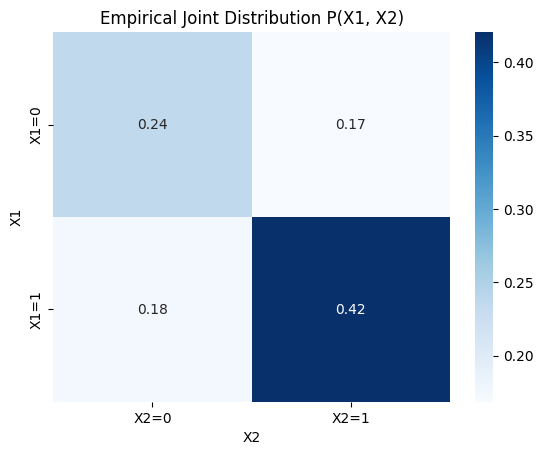

In [27]:
# Plotting the empirical joint distribution
sns.heatmap(joint_distribution, annot=True, fmt=".2f", cmap="Blues", xticklabels=["X2=0", "X2=1"], yticklabels=["X1=0", "X1=1"])
plt.title("Empirical Joint Distribution P(X1, X2)")
plt.xlabel("X2")
plt.ylabel("X1")
plt.show()

Throughout the rest of this section, we will apply Gibbs sampling to the running example. Consider that we also don't know the value of the standard deviation $\sigma$ and wish to find the joint distribution $p(\mu, \sigma | data)$, when
$$p(\mu, \sigma | data) ∝ P(data | \mu) P (\mu) P(\sigma)$$

$$ P(data | \mu) P (\mu) ∝ \frac{1}{8 \pi \sigma^2} e^{\frac{-1}{2 \pi \sigma^2} \left( (3.1 - \mu)^2 + (2.65 - \mu)^2 \right)}$$

We must first specify a prior for $\sigma$. A common one is the Inverse-Gamma distribution, defined as follows:
$$\text{Inverse-Gamma}(x \mid \alpha, \beta) = \frac{\beta^\alpha}{\Gamma(\alpha)} x^{-(\alpha+1)} e^{-\frac{\beta}{x}}, \quad x > 0, \, \alpha > 0, \, \beta > 0$$

We can plot this as follows:

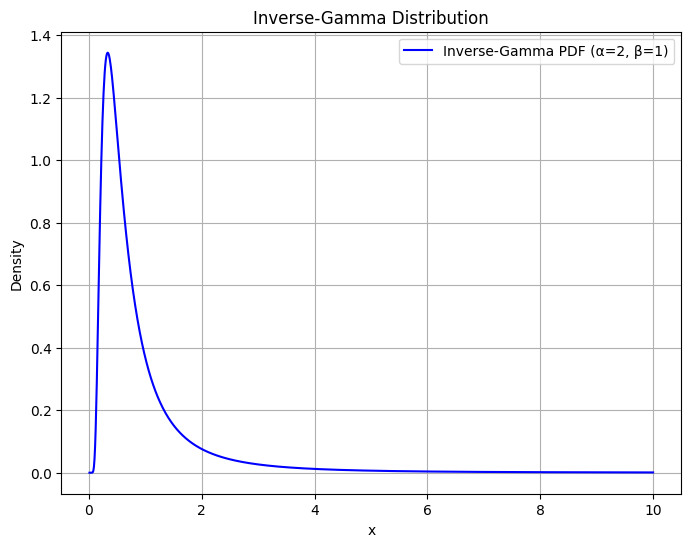

In [28]:
from scipy.stats import invgamma
# Parameters for the Inverse-Gamma distribution
alpha = 2  # Shape parameter
beta = 1   # Scale parameter

# Generate x values for plotting
x = np.linspace(0.01, 10, 1000)

# Compute the Inverse-Gamma PDF
pdf = invgamma.pdf(x, alpha, scale=beta)

# Plot the Inverse-Gamma distribution
plt.figure(figsize=(8, 6))
plt.plot(x, pdf, label=f'Inverse-Gamma PDF (α={alpha}, β={beta})', color='blue')
plt.title('Inverse-Gamma Distribution')
plt.xlabel('x')
plt.ylabel('Density')
plt.grid(True)
plt.legend()
plt.show()

Now we can write the joint posterior:

$$p(\mu,\sigma^2 \mid data)∝\sigma^2 e^ \frac{-1}{2 \sigma^2}((3.1-\mu)^2+(2.65-\mu)^2)\cdot \text{Inverse-Gamma}(\sigma^2\mid \alpha,\beta)$$

and estimate it using Gibbs sampling:

In [29]:
# known data points
data1 = 3.1
data2 = 2.65

# Gibbs Sampling
def gibbs_sampling(n_samples, start_mu, start_sigma2):
    samples_mu = []
    samples_sigma2 = []

    # Initial values
    mu_current = start_mu
    sigma2_current = start_sigma2

    for i in range(n_samples):
        # 1. Sample mu | sigma^2, data
        mu_mean = (data1 + data2) / 2
        mu_variance = sigma2_current / 2
        mu_current = np.random.normal(mu_mean, np.sqrt(mu_variance))

        # 2. Sample sigma^2 | mu, data
        shape = alpha + 1  # Inverse-Gamma shape parameter
        scale = beta + ((data1 - mu_current)**2 + (data2 - mu_current)**2) / 2  # Inverse-Gamma scale parameter
        sigma2_current = invgamma.rvs(a=shape, scale=scale)

        # Store the samples
        samples_mu.append(mu_current)
        samples_sigma2.append(sigma2_current)

    return np.array(samples_mu), np.array(samples_sigma2)


<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-3822699531.py:14: SyntaxWarning: invalid escape sequence '\m'
  plt.title('Sampled Distribution of $\mu$')
/tmp/ipython-input-3822699531.py:15: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('$\mu$')
/tmp/ipython-input-3822699531.py:20: SyntaxWarning: invalid escape sequence '\s'
  plt.title('Sampled Distribution of $\sigma^2$')
/tmp/ipython-input-3822699531.py:21: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('$\sigma^2$')


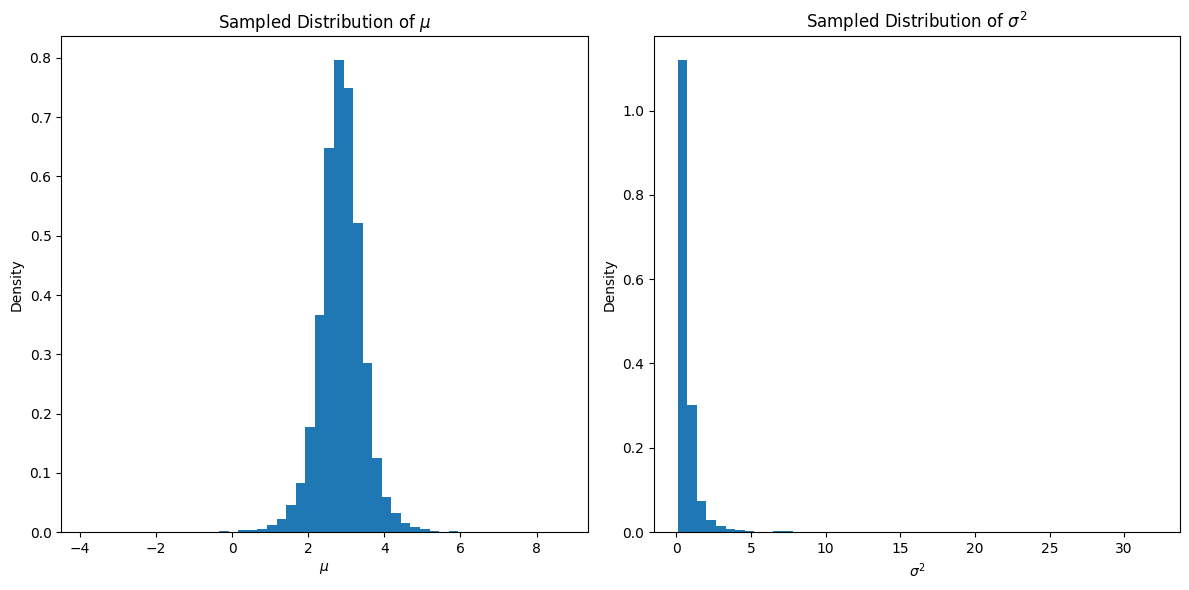

In [30]:

# Parameters for Gibbs sampling
n_samples = 10000
start_mu = 2.0  # Initial guess for mu
start_sigma2 = 1.0  # Initial guess for sigma^2

# Run Gibbs sampling
samples_mu, samples_sigma2 = gibbs_sampling(n_samples, start_mu, start_sigma2)

# Plot the sampled distributions
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(samples_mu, bins=50, density=True)
plt.title('Sampled Distribution of $\mu$')
plt.xlabel('$\mu$')
plt.ylabel('Density')

plt.subplot(1, 2, 2)
plt.hist(samples_sigma2, bins=50, density=True)
plt.title('Sampled Distribution of $\sigma^2$')
plt.xlabel('$\sigma^2$')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

We can also plot the samples similarly to before:

<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-657222824.py:4: SyntaxWarning: invalid escape sequence '\m'
  plt.title('Scatter Plot of $\mu$ and $\sigma^2$ Samples from Gibbs Sampler')
/tmp/ipython-input-657222824.py:5: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('$\mu$')
/tmp/ipython-input-657222824.py:6: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sigma^2$')


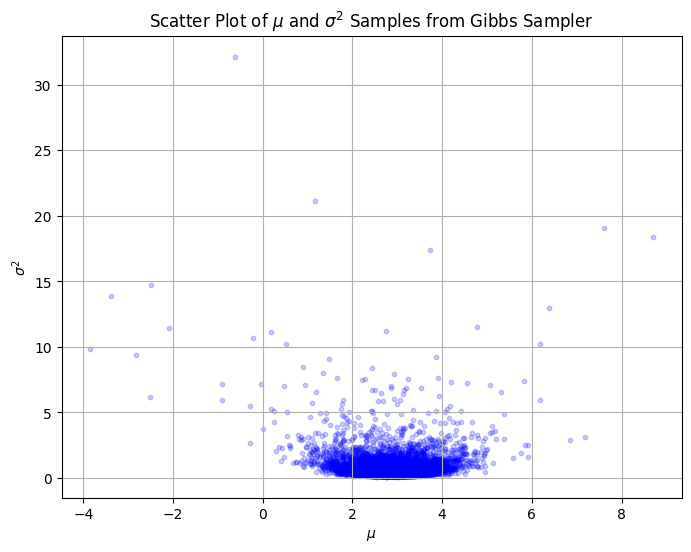

In [31]:
# Scatter plot of the samples
plt.figure(figsize=(8, 6))
plt.scatter(samples_mu, samples_sigma2, alpha=0.2, s=10, color='blue')
plt.title('Scatter Plot of $\mu$ and $\sigma^2$ Samples from Gibbs Sampler')
plt.xlabel('$\mu$')
plt.ylabel('$\sigma^2$')
plt.grid(True)
plt.show()

Looking along the $x$ axis, you can see that the distribution of $\mu$ is similar to Metropolis and Metropolis-Hastings.

### 2.4. Hamiltonian Monte Carlo

Hamiltonian Monte Carlo (HMC) is a more advanced Markov Chain Monte Carlo (MCMC) method used to sample from complex probability distributions, especially in high-dimensional spaces. Unlike the previous methods (Gibbs Sampling), HMC uses Hamiltonian dynamics from physics to explore the target distribution more efficiently. HMC is particularly powerful in Bayesian statistics, where it is used to draw samples from posterior distributions that are difficult to sample from directly.


HMC treats the sampling problem as a physical system where:
- **Position Variables**: Represent the parameters of interest (e.g., the parameters of a Bayesian model).
- **Momentum Variables**: Represent the way to explore the parameter space.

The core idea of HMC is to simulate the dynamics of a particle moving through the parameter space under the influence of a potential energy defined by the negative log probability of the target distribution.

#### Key Components

- **Potential Energy $U(\theta)$**: This is related to the target distribution $p(\theta)$ by $U(\theta) = -\log p(\theta)$. It represents the "energy landscape" that the particle moves through.
- **Kinetic Energy $K(p)$**: Typically defined as $K(p) = \frac{1}{2} p^T M^{-1} p$, where $p$ is the momentum vector and $M$ is the mass matrix (often taken as the identity matrix). This is analogous to the kinetic energy of a physical system.
- **Hamiltonian $H(\theta, p)$**: The total energy of the system, defined as $H(\theta, p) = U(\theta) + K(p)$. The goal is to preserve the Hamiltonian as the particle moves through the space, which ensures that the sampling respects the target distribution.

We first define the log posterior and its differential.

In [32]:
# Log-posterior
def log_posterior(mu, sigma, data):
    if not (mu_prior_min <= mu <= mu_prior_max) or sigma <= 0:
        return -np.inf
    likelihood = -0.5 * np.sum((data - mu) ** 2) / (sigma ** 2) - len(data) * np.log(sigma)
    prior_mu = 0  # Uniform(2, 6) has a flat log prior
    prior_sigma = stats.invgamma.logpdf(sigma**2, alpha, scale=beta)
    return likelihood + prior_mu + prior_sigma

# Gradient of the log-posterior
def grad_log_posterior(mu, sigma, data):
    if not (mu_prior_min <= mu <= mu_prior_max) or sigma <= 0:
        return np.array([-np.inf, -np.inf])

    # Derivatives w.r.t. mu and sigma
    grad_mu = np.sum(data - mu) / (sigma ** 2)
    grad_sigma = -len(data) / sigma + np.sum((data - mu) ** 2) / (sigma ** 3)
    # Gradient of the Inverse-Gamma prior for sigma
    grad_sigma_prior = -(2 * alpha + 1) / sigma + 2 * beta / (sigma ** 3)

    return np.array([grad_mu, grad_sigma + grad_sigma_prior])


Next, we set up the problem, with the prior parameters as well as the observed data.

In [33]:
import scipy.stats as stats  # Used for inverse gamma

# Priors
mu_prior_min = 2
mu_prior_max = 6
alpha = 2  # Inverse-Gamma alpha
beta = 1   # Inverse-Gamma beta

# Data points
data = np.array([3.1, 2.65])

# Number of iterations for HMC
n_iter = 5000
L = 10  # Number of leapfrog steps
epsilon = 0.01  # Step size for leapfrog

# Initialize parameters
mu = 4
sigma = 1

# Store samples
mu_samples = np.zeros(n_iter)
sigma_samples = np.zeros(n_iter)

#### The Leapfrog method

Leapfrog is a numerical method used to simulate the motion of particles in a physical system governed by Newton's laws of motion. It is commonly used in both physics simulations and Hamiltonian Monte Carlo.

The leapfrog method gets its name due to the updates for the position and momentum variables "leaping" over each other. This is similar to HMC, where the algorithm alterates between variables. The key advantage of the leapfrog method is that it conserves energy (approximately) and is reversible, making it well-suited for Hamiltonian dynamics.

Here's a breakdown of the leapfrog algorithm:



1. **Initial State:** Start with the initial values for the position $q$ and momentum $p$.
2. **Half-step for Momentum:** Update the momentum $p$ by half a time step $\frac{\epsilon}{2}$, using the gradient of the potential energy with respect to the position:

$$p ⟵ p - \frac{\epsilon}{2} ∇ V(q)$$

3. **Full-step for Position:** Update the position $q$ by a full time step $\epsilon$, using the updated momentum:

$$ q ← q + \epsilon p$$

4. **Another Half-step for Momentum:** Finally, update the momentum $p$ again by another half time step $\frac{\epsilon}{2}$:

$$p ⟵ p - \frac{\epsilon}{2} ∇ V(q)$$

By combining these steps, the leapfrog method provides an efficient and stable way to simulate the dynamics of the system over time. The python code is as follows:

In [34]:
# Leapfrog method
def leapfrog(mu, sigma, p_mu, p_sigma, epsilon, L, data):
    mu_new = mu
    sigma_new = sigma
    p_mu_new = p_mu - 0.5 * epsilon * grad_log_posterior(mu, sigma, data)[0]
    p_sigma_new = p_sigma - 0.5 * epsilon * grad_log_posterior(mu, sigma, data)[1]

    for _ in range(L):
        mu_new += epsilon * p_mu_new
        sigma_new += epsilon * p_sigma_new
        if _ != L - 1:
            p_mu_new -= epsilon * grad_log_posterior(mu_new, sigma_new, data)[0]
            p_sigma_new -= epsilon * grad_log_posterior(mu_new, sigma_new, data)[1]

    p_mu_new -= 0.5 * epsilon * grad_log_posterior(mu_new, sigma_new, data)[0]
    p_sigma_new -= 0.5 * epsilon * grad_log_posterior(mu_new, sigma_new, data)[1]

    return mu_new, sigma_new, p_mu_new, p_sigma_new


Using the Leapfrog algorithm, the Hamiltonian Monte Carlo algorithm can then be written as follows:

<>:36: SyntaxWarning: invalid escape sequence '\m'
<>:37: SyntaxWarning: invalid escape sequence '\m'
<>:38: SyntaxWarning: invalid escape sequence '\s'
<>:36: SyntaxWarning: invalid escape sequence '\m'
<>:37: SyntaxWarning: invalid escape sequence '\m'
<>:38: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-3403123283.py:36: SyntaxWarning: invalid escape sequence '\m'
  plt.title('Scatter Plot of $\mu$ and $\sigma$ Samples from HMC')
/tmp/ipython-input-3403123283.py:37: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('$\mu$')
/tmp/ipython-input-3403123283.py:38: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sigma$')


Mean of mu samples: 2.9471771962820714
Mean of sigma samples: 0.6993747543795831


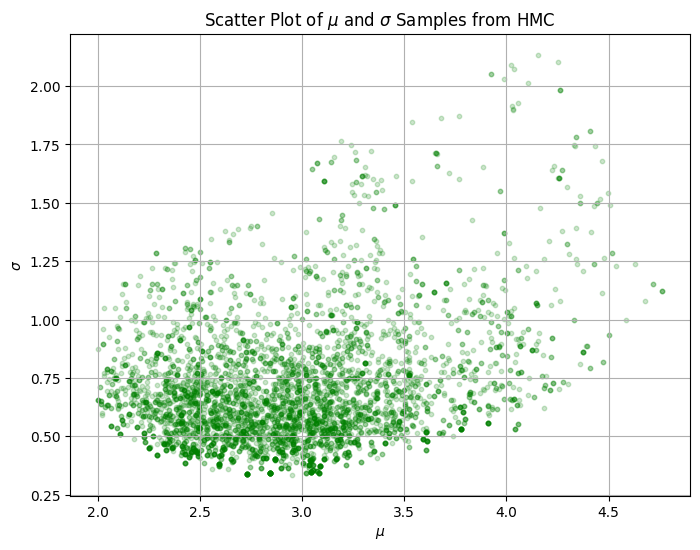

In [35]:
for i in range(n_iter):
    # Sample initial momentum
    p_mu = np.random.randn()
    p_sigma = np.random.randn()

    # Compute Hamiltonian at current state
    current_log_posterior = log_posterior(mu, sigma, data)
    current_H = -current_log_posterior + 0.5 * (p_mu ** 2 + p_sigma ** 2)

    # Propose new state using leapfrog
    mu_new, sigma_new, p_mu_new, p_sigma_new = leapfrog(mu, sigma, p_mu, p_sigma, epsilon, L, data)

    # Compute Hamiltonian at new state
    new_log_posterior = log_posterior(mu_new, sigma_new, data)
    new_H = -new_log_posterior + 0.5 * (p_mu_new ** 2 + p_sigma_new ** 2)

    # Accept or reject the new state based on Metropolis criterion
    if np.random.rand() < np.exp(current_H - new_H):
        mu, sigma = mu_new, sigma_new

    # Store the samples
    mu_samples[i] = mu
    sigma_samples[i] = sigma



# Results
print(f"Mean of mu samples: {np.mean(mu_samples)}")
print(f"Mean of sigma samples: {np.mean(sigma_samples)}")



# Scatter plot of the HMC samples
plt.figure(figsize=(8, 6))
plt.scatter(mu_samples, sigma_samples, alpha=0.2, s=10, color='green')
plt.title('Scatter Plot of $\mu$ and $\sigma$ Samples from HMC')
plt.xlabel('$\mu$')
plt.ylabel('$\sigma$')
plt.grid(True)
plt.show()


In this example, we used Hamiltonian Monte Carlo to sample from a bivariate Gaussian distribution. The Hamiltonian dynamics allow us to efficiently explore the parameter space, even when the distribution is complex. The Leapfrog method is used to simulate the dynamics, ensuring that the sampler preserves the total energy of the system, which helps in generating accurate samples.


# 3  Variational Inference for Gaussian Mean Estimation



## Introduction
In this implementation, we use **Variational Inference (VI)** to approximate the posterior distribution of a Gaussian mean parameter, given observed data. Instead of directly computing the posterior (which may be intractable), we approximate it with a simpler distribution by optimizing the **Evidence Lower Bound (ELBO)**.

## Problem Setup
We assume the observed data **X** follows a Gaussian distribution:

$$
X_i \sim \text{Normal}(\mu, \sigma^2)
$$

where:
- \( $\mu$ \) is the unknown mean (which we aim to infer).
- \( $\sigma^2$ \) is a known variance.

We place a **Gaussian prior** over \( \mu \):

$$
\mu \sim \text{Normal}(\mu_{\text{prior}}, \sigma_{\text{prior}}^2)
$$

Our goal is to approximate the **posterior**:

$$
p(\mu \mid X) \propto p(X \mid \mu) p(\mu)
$$

using a **Gaussian variational distribution**:

$$
q(\mu) = \text{Normal}(\mu_q, \sigma_q^2)
$$

where \( $\mu_q$ \) and \( $\sigma_q^2$ \) are variational parameters.

## Evidence Lower Bound (ELBO)
To optimize ( q($\mu$) ), we maximize the **ELBO**, which is:

$$
\mathbb{E}_{q(\mu)} [\log p(X, \mu)] - \mathbb{E}_{q(\mu)} [\log q(\mu)]
$$

This is equivalent to minimizing the **KL divergence** between \( q(\mu) \) and the true posterior.

## Optimization via Stochastic Gradient Ascent
Since the expectation over \( q(\mu) \) is often intractable, we use **Monte Carlo sampling** and the **Reparameterization Trick**:

1. **Reparameterization Trick:**  
   Instead of sampling \( \mu \sim q(\mu) \), we rewrite it as:

   $$
   \mu = \mu_q + \sigma_q \epsilon, \quad \text{where} \quad \epsilon \sim \text{Normal}(0,1)
   $$

   This allows gradients to flow through \( $\mu_q$ \) and \( $\log \sigma_q$ \).

2. **Gradient Updates:**  
   The gradients for the variational parameters are computed as:

   $$
   \nabla_{\mu_q} ELBO = \sum \frac{(X - \mu)}{\sigma^2} + \frac{(\mu_{\text{prior}} - \mu)}{\sigma_{\text{prior}}^2}
   $$

 $$ \nabla_{\log \sigma_q} \text{ELBO} \approx \left( \sum_{i=1}^{N} \frac{(x_i - \mu_{\text{sample}})}{\sigma^2} \cdot \epsilon - \frac{(\mu_{\text{sample}} - \mu_{\text{prior}})}{\sigma_{\text{prior}}^2} \cdot \epsilon \right) \cdot \sigma_q + 1 $$
3. **Gradient Clipping & Parameter Updates:**  
   - The gradients are clipped for numerical stability.
   - Parameters \( $\mu_q$ \) and \( $\log \sigma_q$ \) are updated using **stochastic gradient ascent**.

## Visualization
1. **ELBO Convergence:** We track and plot the ELBO values over iterations.
2. **Comparison of Distributions:** We visualize the prior and learned variational posterior, along with the true mean \($ \mu$ \).

---
This approach provides an efficient way to approximate Bayesian inference for Gaussian models, demonstrating the power of Variational Inference with the reparameterization trick.

## Task
1. Write the code for computing the gradient for the ELBO loss.


Variational mean (mu_q): 4.806
Variational standard deviation (sigma_q): 0.973


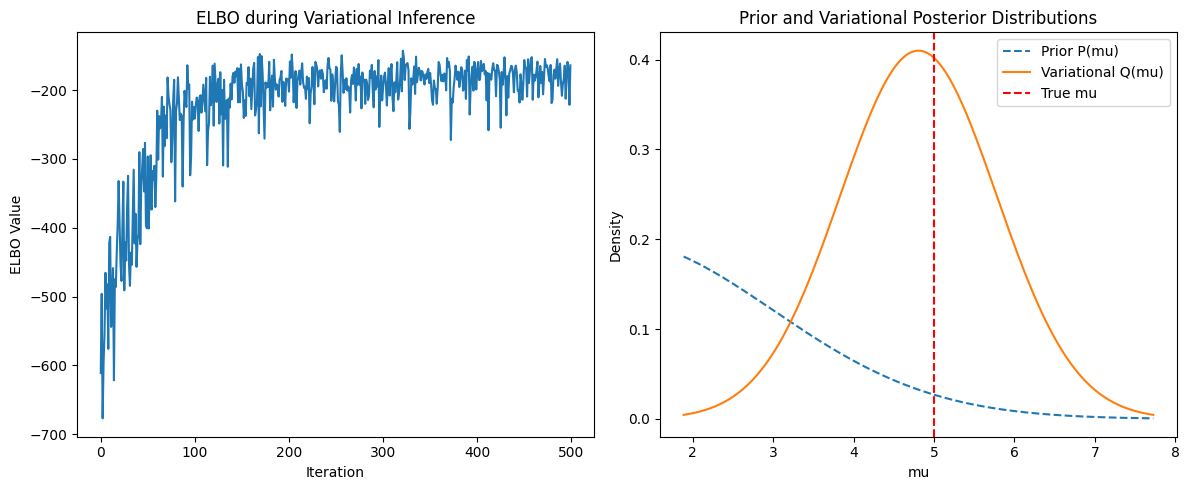

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm  # Importing normal distribution functions for PDFs

# =========================
# Data Generation
# =========================
np.random.seed(42)  # Set seed for reproducibility
true_mu = 5.0  # True mean of the data
sigma = 1.0    # Known standard deviation (likelihood noise)
X = np.random.normal(true_mu, sigma, 100)  # Generate 100 data points

# =========================
# Prior (Gaussian Distribution)
# =========================
mu_prior = 1.0  # Prior mean for mu
sigma_prior = 2.0  # Prior standard deviation

# =========================
# Variational Parameters (Posterior Approximation)
# =========================
mu_q = 2.0  # Initial mean estimate for variational posterior
log_sigma_q = np.log(1.0)  # Initial log of standard deviation (log-transformed for stability)

# =========================
# Optimization Settings
# =========================
learning_rate = 0.0001  # Small learning rate for stable updates
num_iterations = 500  # Number of optimization steps

# Gradient clipping to prevent instability in training
grad_clip = 1.0  # Maximum absolute gradient value allowed
log_sigma_q_clip_range = 20.0  # Prevents overflow (e^20 is still a large std deviation but avoids infinity)

elbo_history = []  # Store ELBO values for monitoring convergence

# =========================
# Variational Inference Loop
# =========================
for i in range(num_iterations):
    # Step 1: Reparameterization trick - Sample from q(mu)
    epsilon = np.random.normal(0, 1)  # Draw from standard normal distribution
    mu_sample = mu_q + np.exp(log_sigma_q) * epsilon  # Transform to match q(mu)

    # Step 2: Compute Gradients

    ## Put your code here ##
    # --- Gradient for mu_q ---
    likelihood_grad_mu = np.sum((X - mu_sample) / (sigma**2))
    prior_grad_mu = (mu_prior - mu_sample) / (sigma_prior**2)
    grad_mu_q = likelihood_grad_mu + prior_grad_mu

    # --- Gradient for log_sigma_q ---
    likelihood_grad_log_sigma_sum = np.sum((X - mu_sample) / (sigma**2)) * epsilon
    prior_grad_log_sigma_term = (mu_sample - mu_prior) / (sigma_prior**2) * epsilon

    # Full expression uses the current sigma_q
    grad_log_sigma_q = (likelihood_grad_log_sigma_sum + prior_grad_log_sigma_term) * np.exp(log_sigma_q) + 1


    # Step 3: Gradient Clipping
    grad_log_sigma_q = np.clip(grad_log_sigma_q, -grad_clip, grad_clip)

    # Step 4: Update Variational Parameters
    mu_q += learning_rate * grad_mu_q
    log_sigma_q += learning_rate * grad_log_sigma_q

    # Step 5: Clip log_sigma_q to avoid numerical instability
    log_sigma_q = np.clip(log_sigma_q, -log_sigma_q_clip_range, log_sigma_q_clip_range)

    # =========================
    # ELBO Calculation (Monte Carlo Estimate for Monitoring)
    # =========================
    n_elbo_samples = 10  # Number of samples for ELBO estimation per iteration
    elbo_sum_plot = 0
    for _ in range(n_elbo_samples):
        mu_sample_elbo = mu_q + np.exp(log_sigma_q) * np.random.normal(0, 1)  # Sample mu
        log_joint = np.sum(norm.logpdf(X, loc=mu_sample_elbo, scale=sigma)) + norm.logpdf(mu_sample_elbo, loc=mu_prior, scale=sigma_prior)  # log P(X, mu)
        log_variational_density = norm.logpdf(mu_sample_elbo, loc=mu_q, scale=np.exp(log_sigma_q))  # log q(mu)
        elbo_sum_plot += log_joint - log_variational_density  # ELBO contribution

    current_elbo = elbo_sum_plot / n_elbo_samples  # Average ELBO estimate
    elbo_history.append(current_elbo)  # Store ELBO value

# =========================
# Final Variational Parameters
# =========================
sigma_q = np.exp(log_sigma_q)  # Convert log_sigma_q back to standard deviation
print(f"Variational mean (mu_q): {mu_q:.3f}")
print(f"Variational standard deviation (sigma_q): {sigma_q:.3f}")

# =========================
# Plot Results
# =========================
plt.figure(figsize=(12, 5))  # Define figure size

# --- Plot 1: ELBO Convergence ---
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(elbo_history)
plt.title('ELBO during Variational Inference')
plt.xlabel('Iteration')
plt.ylabel('ELBO Value')

# --- Plot 2: Prior vs Variational Posterior ---
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
mu_range = np.linspace(mu_q - 3*sigma_q, mu_q + 3*sigma_q, 200)  # Range for mu visualization
prior_pdf = norm.pdf(mu_range, loc=mu_prior, scale=sigma_prior)  # Compute Prior density
variational_posterior_pdf = norm.pdf(mu_range, loc=mu_q, scale=sigma_q)  # Compute Posterior density

plt.plot(mu_range, prior_pdf, linestyle='--', label='Prior P(mu)')  # Plot Prior
plt.plot(mu_range, variational_posterior_pdf, label='Variational Q(mu)')  # Plot Posterior
plt.axvline(x=true_mu, color='r', linestyle='--', label='True mu')  # Indicate true mean
plt.title('Prior and Variational Posterior Distributions')
plt.xlabel('mu')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()  # Adjust layout to prevent overlapping elements
plt.show()


<details>
<summary>Derivation for the gradiant calculatuon</summary>



# Derivation of Analytical Gradient for ELBO (Gaussian Prior, Gaussian Posterior)

## 1. Definition of ELBO
The Evidence Lower Bound (ELBO) is defined as:

$$ \text{ELBO}(q) = \mathbb{E}_{q(\mu)} [\log P(\mathbf{X}, \mu) - \log q(\mu)] $$

Expanding the joint probability:

$$ \log P(\mathbf{X}, \mu) = \log P(\mathbf{X} | \mu) + \log P(\mu) $$

we get:

$$ \text{ELBO}(q) = \mathbb{E}_{q(\mu)} [\log P(\mathbf{X} | \mu) + \log P(\mu) - \log q(\mu)] $$

We aim to compute the gradients of ELBO with respect to the variational parameters.

## 2. Gradient with Respect to \( \mu_q \)
Using the reparameterization trick:

$$ \mu = \mu_q + \sigma_q \cdot \epsilon, \quad \epsilon \sim \mathcal{N}(0,1) $$

The gradient of ELBO with respect to \( \mu_q \) is:

$$ \nabla_{\mu_q} \text{ELBO} = \mathbb{E}_{\epsilon \sim \mathcal{N}(0,1)} \left[ \nabla_{\mu_q} (\log P(\mathbf{X} | \mu) + \log P(\mu) - \log q(\mu)) \right] $$

**Gradient of Log-Likelihood Term:**

$$ \nabla_{\mu_q} \log P(\mathbf{X} | \mu) = \sum_{i=1}^{N} \frac{x_i - (\mu_q + \sigma_q \cdot \epsilon)}{\sigma^2} $$

**Gradient of Prior Term:**

$$ \nabla_{\mu_q} \log P(\mu) = \frac{\mu_{\text{prior}} - (\mu_q + \sigma_q \cdot \epsilon)}{\sigma_{\text{prior}}^2} $$

**Gradient of Variational Term:**

$$ \nabla_{\mu_q} \log q(\mu) = 0 $$

Thus, combining these:

$$ \nabla_{\mu_q} \text{ELBO} = \sum_{i=1}^{N} \frac{x_i - \mu_q}{\sigma^2} + \frac{\mu_{\text{prior}} - \mu_q}{\sigma_{\text{prior}}^2} $$

## 3. Gradient with Respect to \( \log \sigma_q \)
The gradient is:

$$ \nabla_{\log \sigma_q} \text{ELBO} = \mathbb{E}_{\epsilon \sim \mathcal{N}(0,1)} \left[ \nabla_{\log \sigma_q} (\log P(\mathbf{X} | \mu) + \log P(\mu) - \log q(\mu)) \right] $$

**Gradient of Log-Likelihood Term:**

$$ \nabla_{\log \sigma_q} \log P(\mathbf{X} | \mu) = \sum_{i=1}^{N} \frac{(x_i - (\mu_q + \sigma_q \cdot \epsilon))}{\sigma^2} \cdot \epsilon \cdot \sigma_q $$

**Gradient of Prior Term:**

$$ \nabla_{\log \sigma_q} \log P(\mu) = - \frac{(\mu_q + \sigma_q \cdot \epsilon - \mu_{\text{prior}})}{\sigma_{\text{prior}}^2} \cdot \epsilon \cdot \sigma_q $$

**Gradient of Variational Term:**

$$ \nabla_{\log \sigma_q} \log q(\mu) = -1 $$

Combining these, we get:

$$ \nabla_{\log \sigma_q} \text{ELBO} \approx \left( \sum_{i=1}^{N} \frac{(x_i - \mu_{\text{sample}})}{\sigma^2} \cdot \epsilon - \frac{(\mu_{\text{sample}} - \mu_{\text{prior}})}{\sigma_{\text{prior}}^2} \cdot \epsilon \right) \cdot \sigma_q + 1 $$

where \( \mu_{\text{sample}} = \mu_q + \sigma_q \cdot \epsilon \).
</details>
